

# Unsupervised Learning

<a target="_blank" href="https://colab.research.google.com/github/alpha-davidson/ICTP-IAEA-2023/blob/main/Activity2_AE.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Autoencoders


Today we will use `keras` in `tensorflow` to build two autoencoders. 

We will start with a simple neural network architecture that is composed of an input layer a lower-dimensional latent space, and an output layer of equal size.

<img src="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-06-at-3.17.13-PM.png" width="400" />

Autoencoders are an **unsupervised learning** method. We will begin by using an **autoencoder to create a latent space representation** of the `digits` dataset, a reduced-dimension version of the `MNIST` dataset. Replacing the `digits` dataset with the larger `MNIST` dataset is perhaps a more useful activity, but increases the runtime of the algorithm.

We will then extend this to create an autoencoder for the [AT-TPC data](https://github.com/CompPhysics/MachineLearning).

In [1]:
import os
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import datasets, cluster # for k-means clustering
from sklearn.cluster import KMeans
import random # if we want to create a Variational Autoencoder
# This is simply an alias for convenience
layers = tf.keras.layers

2023-05-25 14:56:02.934809: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-25 14:56:03.091574: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-25 14:56:03.092836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 14:56:03.846306: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# useful functions

def load_attpc_data():
    """Loads in the AT-TPC data.
        
    Returns:
        A tuple of the form ((real_features, real_targets), (simulated_features, simulated_targets))
    """
    simulated_data_origin = 'https://github.com/CompPhysics/MachineLearningMSU/raw/master/Day2_materials/data/simulated-attpc-events.h5'
    real_data_origin = 'https://github.com/CompPhysics/MachineLearningMSU/raw/master/Day2_materials/data/real-attpc-events.h5'
    
    simulated_path = tf.keras.utils.get_file('simulated-attpc-data.h5', origin=simulated_data_origin)
    real_path = tf.keras.utils.get_file('real-attpc-data.h5', origin=real_data_origin)
    
    with h5py.File(simulated_path, 'r') as h5:
        simulated_features = h5['features'][:]
        simulated_targets = h5['targets'][:]
        
    with h5py.File(real_path, 'r') as h5:
        real_features = h5['features'][:]
        real_targets = h5['targets'][:]
    
    return (real_features, real_targets), (simulated_features, simulated_targets)

def plot_learning_curve(history):
    """Plots a learning curve from a training history.
    
    Arguments:
        history (dict): The training history returned by `model.fit()`.
        
    Returns:
        None.
    """
    plt.figure(figsize=(11, 6), dpi=100)
    plt.plot(history.history['loss'], 'o-', label='Training Loss')
    plt.plot(history.history['val_loss'], 'o:', color='r', label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(0, len(history.history['loss'])), range(1, len(history.history['loss']) + 1))
    plt.show()

## Data exploration

As usual, we begin by loading our data, normalizing it, and putting it into the approporate format for our model. In this case, we need 1D arrays for our fully connected architecture. 

In [3]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [4]:
print('Training Features:\n   Shape: {}\n   Type: {}\n'.format(x_train.shape, x_train.dtype))

Training Features:
   Shape: (60000, 28, 28)
   Type: uint8



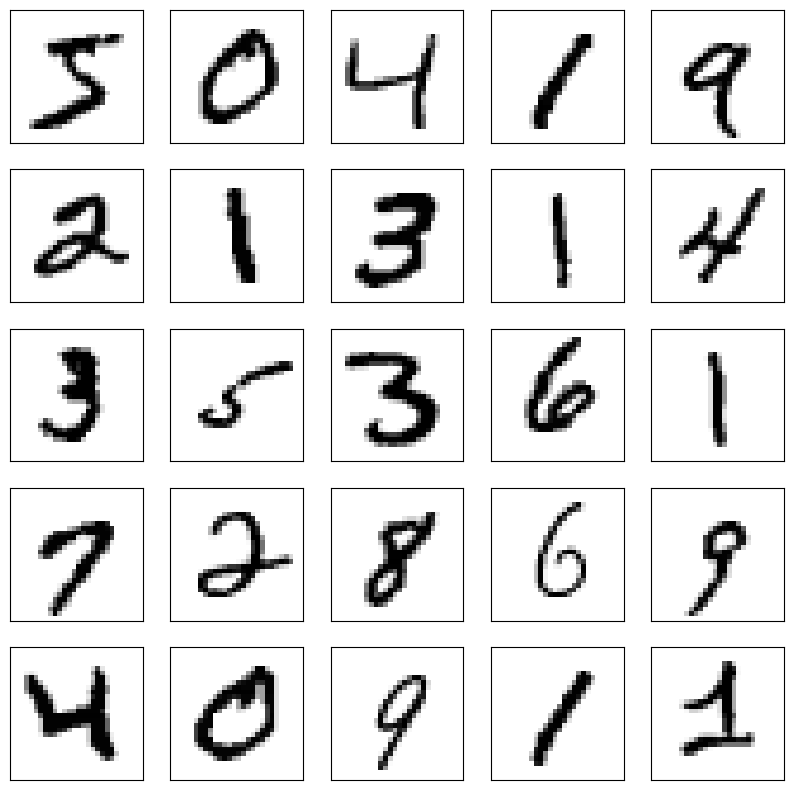

In [5]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    
plt.show()

### Next, we rescale the data. Here, I rescaled the images to [0,1].

In [6]:
x_train = x_train / 255.
x_test = x_test / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


Now we build the autoencoder. Ours is a standard feed-forward neural network architecture with three layers as descibed above.

Let's start by reducing our dimensionality by a factor of two and see if we can recover our original images.

One way to build an autoencoder is to store each layer into a variable so that we can access the different pieces later. 

*Note: I achieved my best performance with a `relu` activation function on both the encoded and output layers.*

In [7]:
latent_dim = 128

input_img = layers.Input(shape=(784,))

latent_layer = layers.Dense(latent_dim, activation="relu")(input_img)

latent_input = layers.Input(shape=(latent_dim,))

output_layer = layers.Dense(784, activation='relu')(latent_input)

2023-05-25 15:00:10.026247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-25 15:00:10.026964: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Now, we build the encoder and decoder from the same layers.

Let's start with the encoder:

In [8]:
# this model maps an input to its encoded representation
encoder = tf.keras.models.Model(input_img, latent_layer)

Now, for the decoder. This requires slightly more work because we want to have a latent representation as an Input in order to use the decoder as a generator.

In [9]:
# create a placeholder for an encoded (32-dimensional) input
latent_input = layers.Input(shape=(latent_dim,))

out = layers.Dense(784, activation='relu')(latent_input)
decoder = tf.keras.models.Model(latent_input, out)

# put the layers together to create your Model
autoencoder = tf.keras.models.Model(input_img, decoder(encoder(input_img)))

### Build the model...

In [10]:
opt = tf.keras.optimizers.Adam(lr = 0.0001)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

### Now, train!

In [11]:
autoencoder.fit(x_train, x_train,
                epochs=40,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/40
235/235 [==============================] - 2s 5ms/step - loss: 0.2603 - val_loss: 0.1985
Epoch 2/40
235/235 [==============================] - 1s 5ms/step - loss: 0.1943 - val_loss: 0.1835
Epoch 3/40
235/235 [==============================] - 1s 5ms/step - loss: 0.1907 - val_loss: 0.1920
Epoch 4/40
235/235 [==============================] - 1s 5ms/step - loss: 0.1780 - val_loss: 0.1664
Epoch 5/40
235/235 [==============================] - 1s 5ms/step - loss: 0.1966 - val_loss: 0.1797
Epoch 6/40
235/235 [==============================] - 1s 5ms/step - loss: 0.1974 - val_loss: 0.2297
Epoch 7/40
235/235 [==============================] - 1s 5ms/step - loss: 0.2091 - val_loss: 0.1815
Epoch 8/40
235/235 [==============================] - 1s 5ms/step - loss: 0.2111 - val_loss: 0.1973
Epoch 9/40
235/235 [==============================] - 1s 5ms/step - loss: 0.1865 - val_loss: 0.1742
Epoch 10/40
235/235 [==============================] - 1s 5ms/step - loss: 0.1739 - val_loss: 0.1621

In [12]:
# encode and decode digits from the test det

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 669us/step


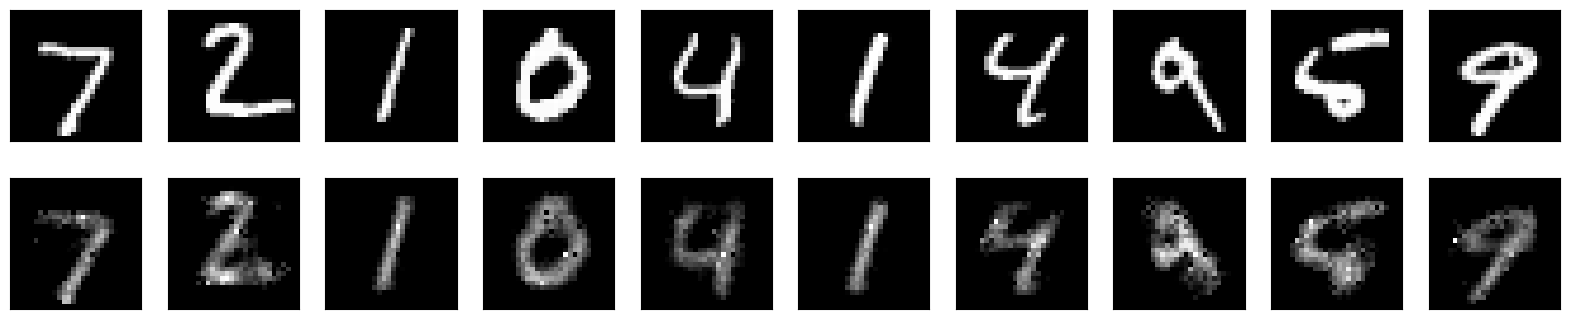

In [13]:

import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


### We can try k-means clustering on the latent space to see if we can separate numbers

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [15]:
clust = KMeans(n_clusters=10).fit(encoded_imgs)

/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fae703d7910>
Traceback (most recent call last):
  File "/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/kchina

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fae999d7d90>
Traceback (most recent call last):
  File "/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fae99f11d80>
Traceback (most recent call last):
  File "/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


[6 5 3 ... 1 4 7]
[6 5 3 ... 1 4 7]


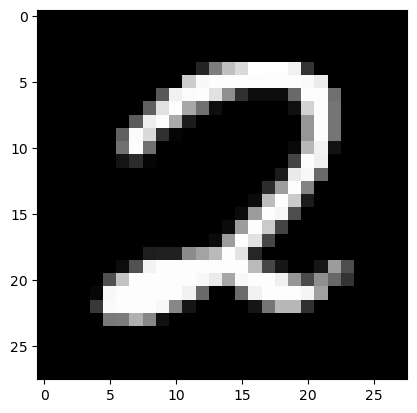

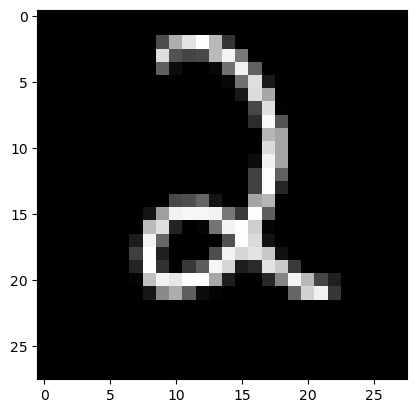

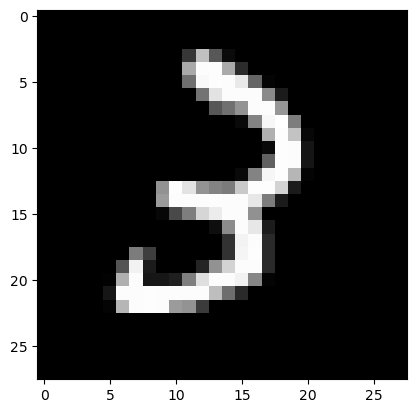

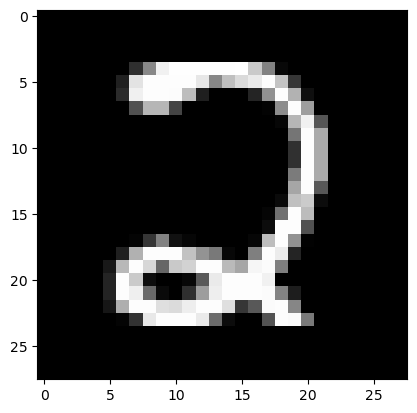

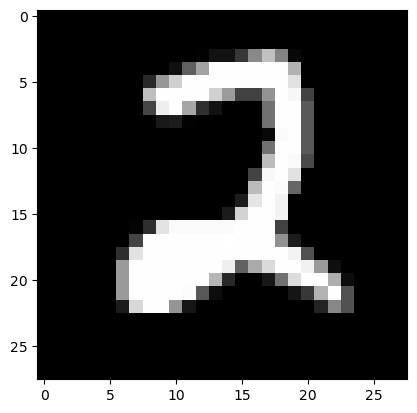

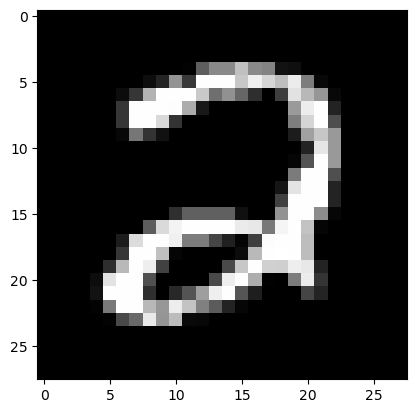

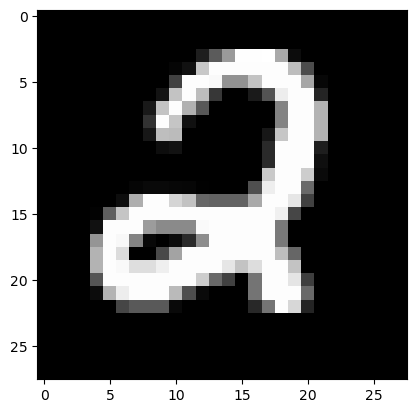

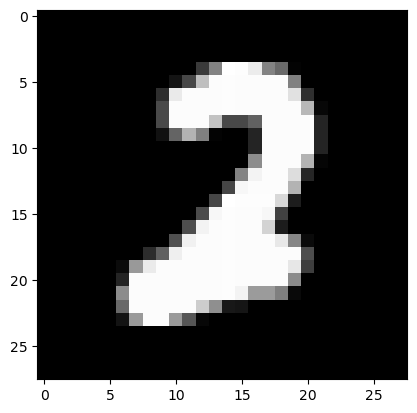

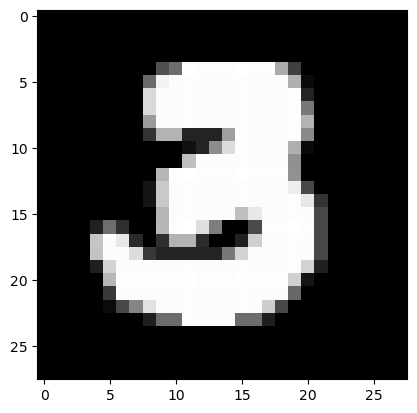

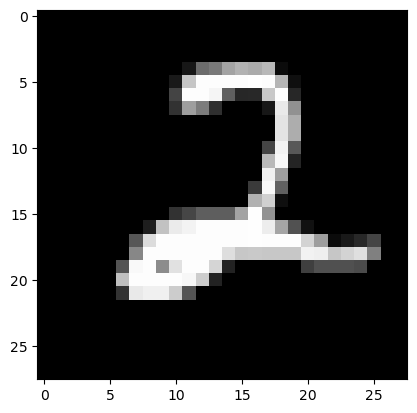

In [16]:
print(clust.labels_)
print(clust.predict(encoded_imgs))
#print(clust.cluster_centers_)
ind = np.where(clust.labels_ == 0)[0][:10]
for i in ind:
    plt.imshow(x_test[i].reshape((28,28)))
    plt.show()

# AT-TPC data

Now that you have some experience, try to build an autoencoder for the AT-TPC data! I am leaving this open-ended so that you can think through all of the necessary steps and choices.

First, we load real and simulated data:

In [17]:
(real_features, _), (sim_features, _) = load_attpc_data()

44061313/44061313 [==============================] - 2s 0us/step


Let's remind ourselves of the shape of this data:

In [18]:
print('Real Features:\n   Shape: {}\n   Type: {}\n'.format(real_features.shape, real_features.dtype))
print('Simulated Features:\n   Shape: {}\n   Type: {}\n'.format(sim_features.shape, sim_features.dtype))

Real Features:
   Shape: (2689, 128, 128)
   Type: uint8

Simulated Features:
   Shape: (50000, 128, 128)
   Type: uint8



If running this notebook on Google Colab, you may not be able to fit all 50,000 simulated events in RAM. Run the cell below to use only 10,000.

In [19]:
sim_features = sim_features[:10000]

#### Experimental data

We visualize the first 25 examples from the experimental dataset below. We no longer have class information.

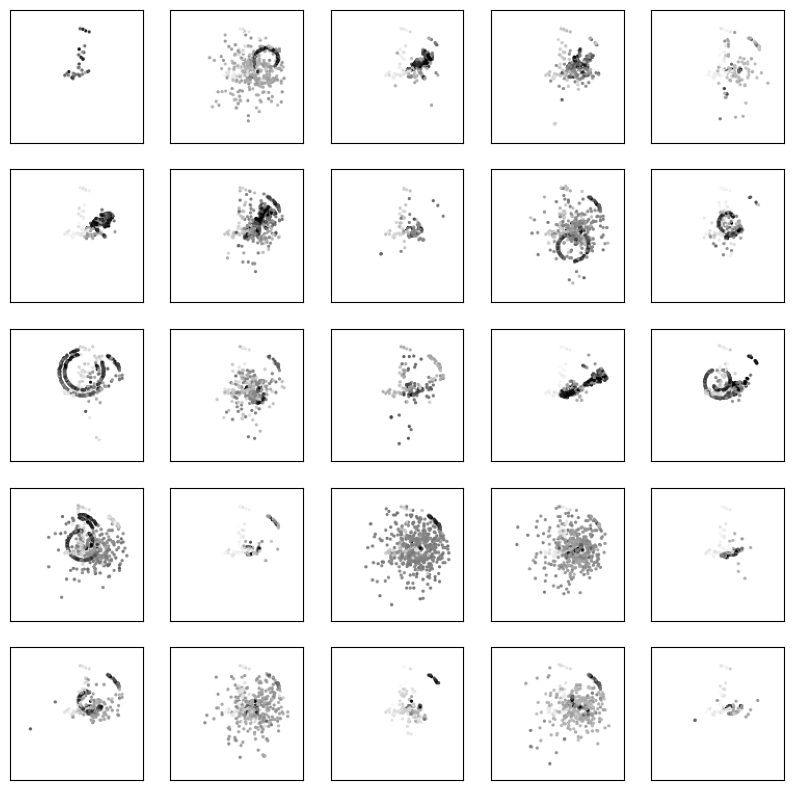

In [20]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(real_features[i], cmap='gray')
    
plt.show()

#### Simulated data

And now we again visualize the first 25 examples from the simulated dataset.

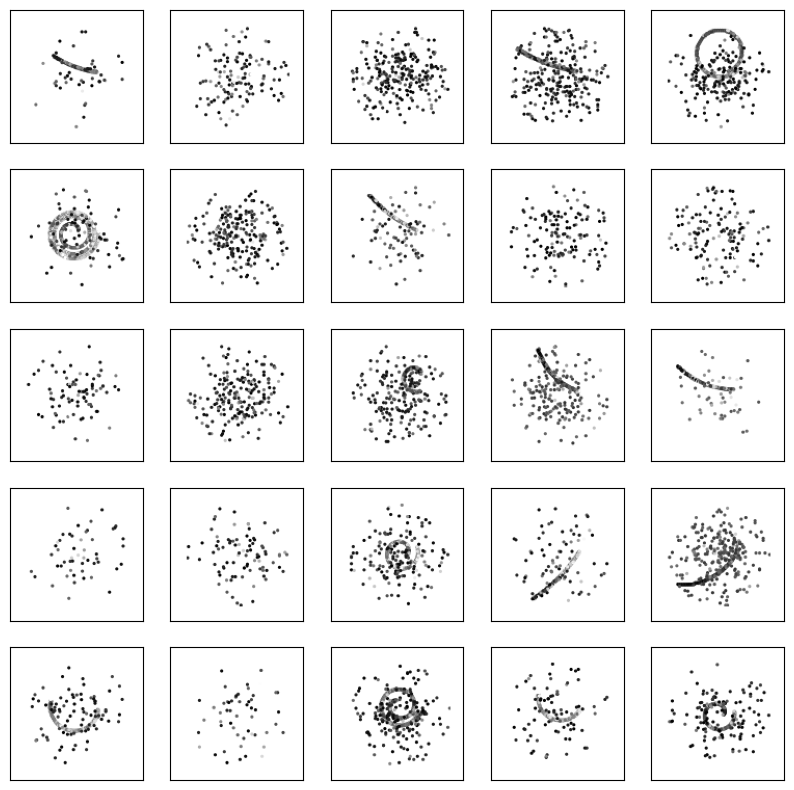

In [21]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sim_features[i], cmap='gray')
    
plt.show()

### And now, I leave you to think through the next steps!

*(Hint, don't forget to preprocess your data!)*